In [5]:
## Options
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Imports

## Mac imports
import sys
toolPath = r'/Users/decolvin/Box Sync/UCD_ECO_coding/mypy'
sys.path.append(toolPath)

## Main Imports

import mnv13 as mnv
print(mnv.version)

from PI_client import pi_client
pi = pi_client()
print("Success!")

/Users/decolvin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Version 1.3
Success!


### Local Data Loading

In [ ]:
# filePath = 'data/OATtest.xlsx'
#filePath = r'/Users/decolvin/Downloads/GBSF Data 061318.csv'
#filePath = 'data/arc2yeardata.xlsx'
#data = pd.read_excel(filePath, header=0, index_col=0, parse_date=True)
#data = pd.read_csv(filePath, header=0, index_col=0, parse_dates=True)
#print(data.columns)

### PI Data Loading

In [29]:
tags = pi.search_by_point('*vet*med*equine*')[0]
#tags += pi.search_by_point('*shields*kbtu*')[0]

tags

[u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Chilled_Water',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Chilled_Water_Demand',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Condensate',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Condensate_Demand',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Domestic_Water',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Domestic_Water_Demand',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Electricity',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Electricity_Demand',
 u'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Steam_Demand']

#### Pull tags

In [41]:
tags_selected = ['Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Chilled_Water_Demand',
 'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Electricity_Demand',
 'Vet_Med_Equine_Athletic_Performance_Lab_MBH1/Steam_Demand']

startDate = '2016-01-01'
endDate = '*'
interval = '1 hour' #Can be "minute" "hour" "day"
calculation = 'calculated' # Redundant?

data = pi.get_stream_by_point(tags_selected, start=startDate, end=endDate, interval=interval, calculation=calculation)

<Response [200]>
<Response [200]>
<Response [200]>


# Data Section

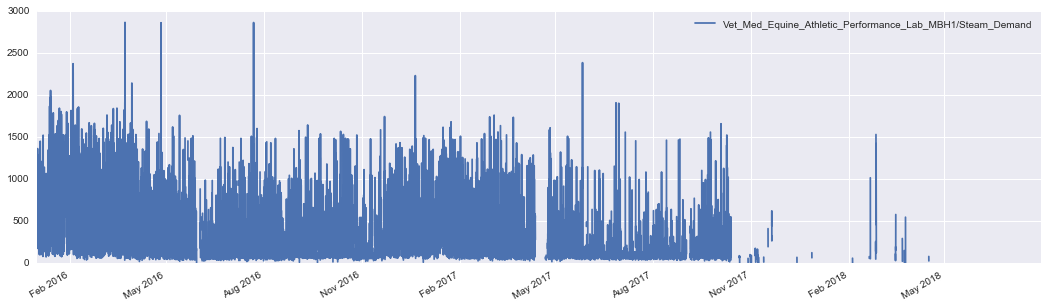

In [42]:
data.iloc[:,2].plot(figsize=(18,5), legend=True)
plt.show()

Q(75%): 443.17 Q(25%): 84.08
IQR value is 359.10
Ceiling adjusted by IQR - Now 1879.56


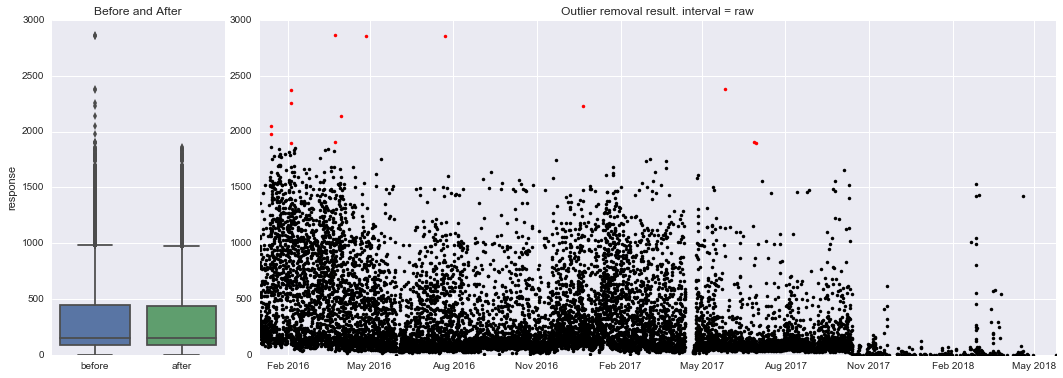

Deprecation warning: this function should be called calculate_degree_hours(). Use that name instead
OAT being loaded from master file


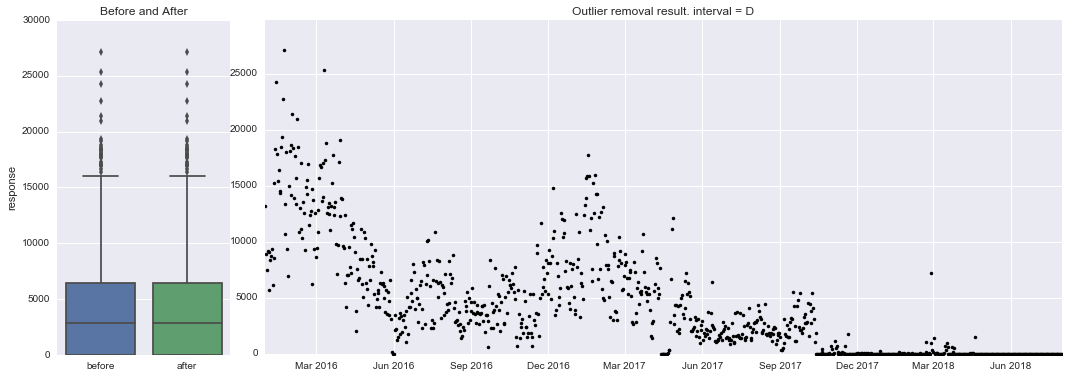

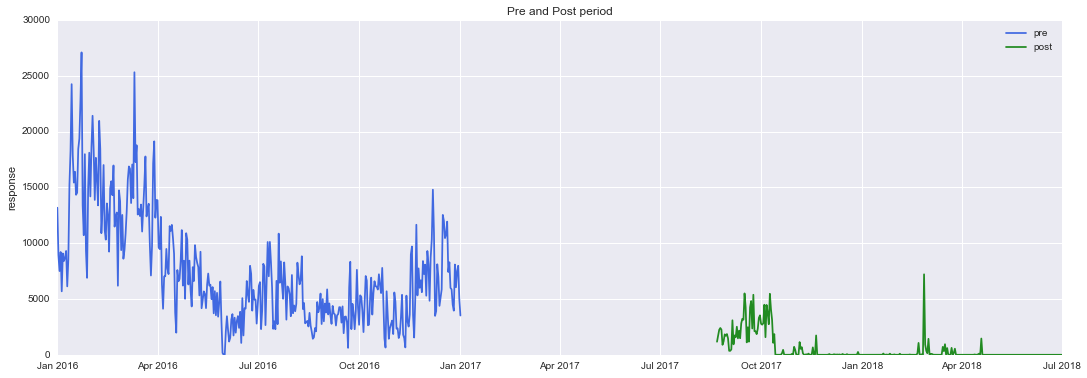

In [44]:
data.rename(columns={data.columns[2]:"response"},inplace=True)

inputDict = {'IQRmult' : 4.0,
             'IQR' : 'y', 
             'resampleRate' : 'D', #'D' for daily 'H' for hourly
             'verbosity' : 3,
             'sliceType' : 'ranges', #half, middate, ranges
             'midDate' : '2017-01-01', #only needed with sliceType : 'middate'
             'dateRanges' : ['2016-01-01','2017-01-01','2017-08-22','2018-07-01'], #only needed with sliceType : 'ranges'
             'OATsource' : 'file', #'self' or 'file'
             'OATname' : 'OAT', #Name of OAT column if OATsource is 'self'} #only needed with sliceType : 'ranges'
            }

dc = mnv.data_handler(data['response'], inputDict)
dc.default_clean()

## Run the next line incase the y-range is FUBAR
dc._outlier_plot(dc.modifiedData[dc.com], yrange=(-100,dc.modifiedData[dc.com].max()*1.1)) 

# plot 3
dc._pre_post_plot()

# Many Linear Models

In [45]:
dc.pre.columns

Index([u'response', u'HDH', u'CDH', u'HDH2', u'CDH2', u'year', u'month', u'dayofmonth', u'hour', u'minute', u'dayofweek', u'weekofyear', u'daytime', u'weekday', u'saturday', u'sunday'], dtype='object')

[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
[]
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
['month']
['weekday']
['month']
['weekday']
['month', 'weekday']
        AIC       AR2        R2    cvrmse     postDiff                              params                                            summary
20  5529.84  0.624349  0.641073  0.394835  2.38053e+06         HDH + C(month) + C(weekday)                              OLS Regression Res...
19  5530.74  0.621974  0.637509  0.396081   2.3821e+06                      HDH + C(month)                 

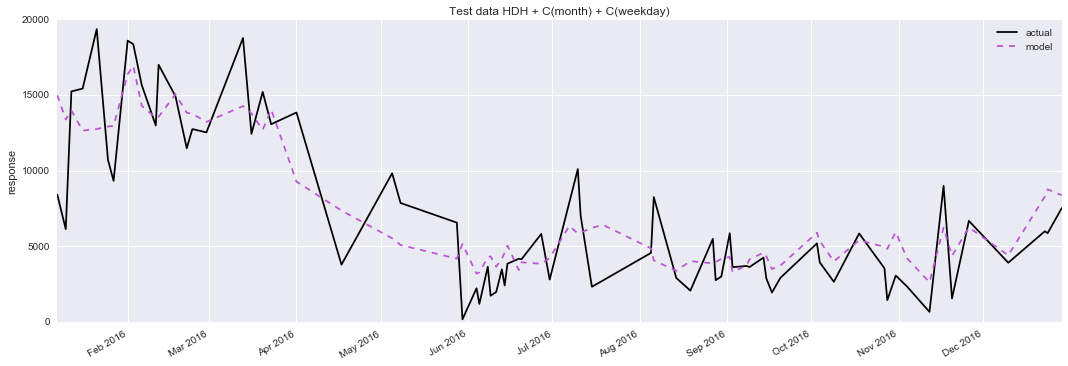

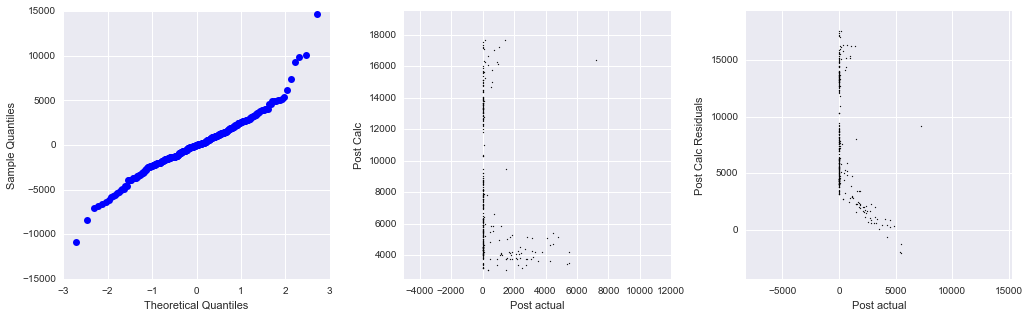

In [53]:
modelDict = {'params': 'CDH + HDH + C(month) + C(weekday)',
             'testTrainSplit': 'random',
             'randomState': 123,
             'testSize': 0.2,
             'commodityRate': (1.0/1000*6),
             'paramList': ['','C(month)','C(weekday)']}

allmod = mnv.many_ols(dc.pre, dc.post, modelDict)

allmod.run_all_linear()
print(allmod.statsPool[0:10])
allmod.plot_pool(1)

# Single Linear Model

['month', 'weekday']


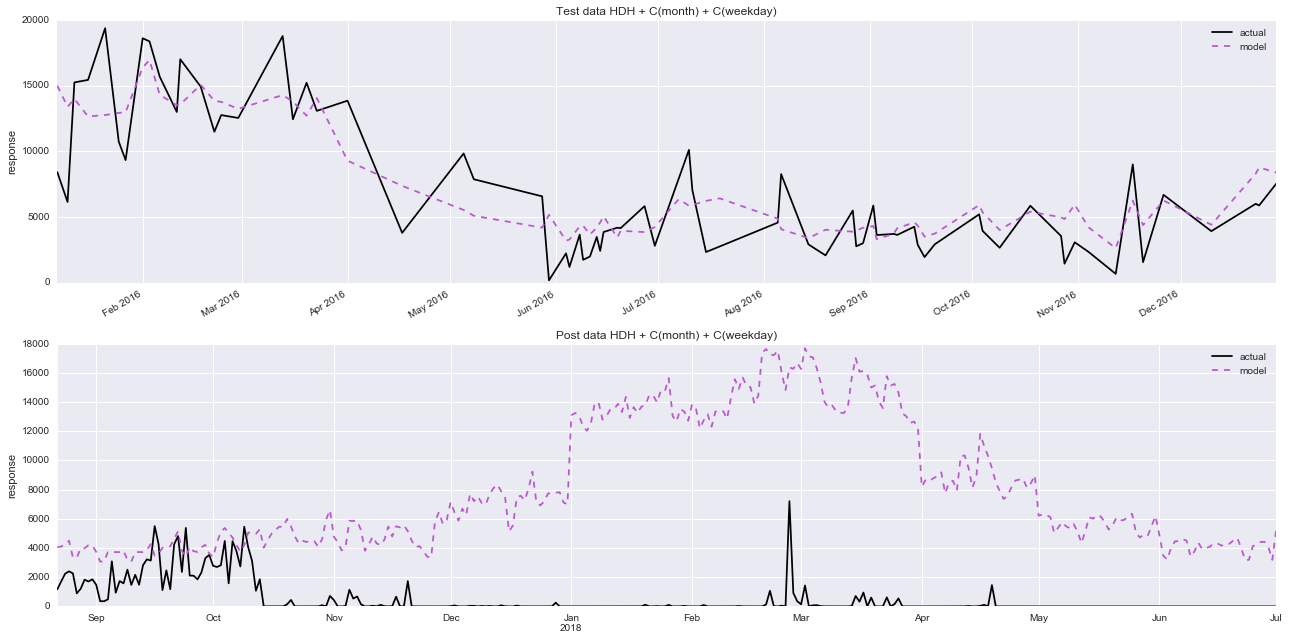

                 VIF
const      41.446231
HDH         4.691784
month_2     1.989238
month_3     2.451376
month_4     3.150609
month_5     3.394411
month_6     3.035713
month_7     3.860401
month_8     3.526513
month_9     3.246919
month_10    2.973998
month_11    2.159284
month_12    1.974503
weekday_1   1.021949


In [54]:
modelDict['params'] = allmod.statsPool.iloc[0]['params']
mod = mnv.ols_model(dc.pre, dc.post, modelDict)
mod.model_plot()


plt.show() # Show plot before Stats summary
print(mod.vif)
#mod.Fit.summary()

In [55]:
mod.kfold()
#print('')
#print("Stats over each fold:") 
#print(mod.kfoldStats)
#print('')
#print("Relative error over each fold")
#print(mod.kfoldRelative.round(1))
#print('')
#print("Accuracy (Mean): %0.2f (+/- %0.2f)" % (np.sqrt(mod.kfoldStats.mean()[2]), np.sqrt(mod.kfoldStats.std()[2])))
#print("Accuracy (Hi/Lo): %0.2f, %0.2f)" % (np.sqrt(mod.kfoldStats.mean()[2])+np.sqrt(mod.kfoldStats.std()[2]), np.sqrt(mod.kfoldStats.mean()[2])-np.sqrt(mod.kfoldStats.std()[2])))

(0.2, 'nfolds', 5)


In [56]:
print ("CV CVRMSE: %.4f") %(np.sqrt(mod.kfoldRelative[5])/dc.pre.response.mean())

CV CVRMSE: 0.3834


### Savings

Savings = $14283.19
Savings = 2380532 klbs


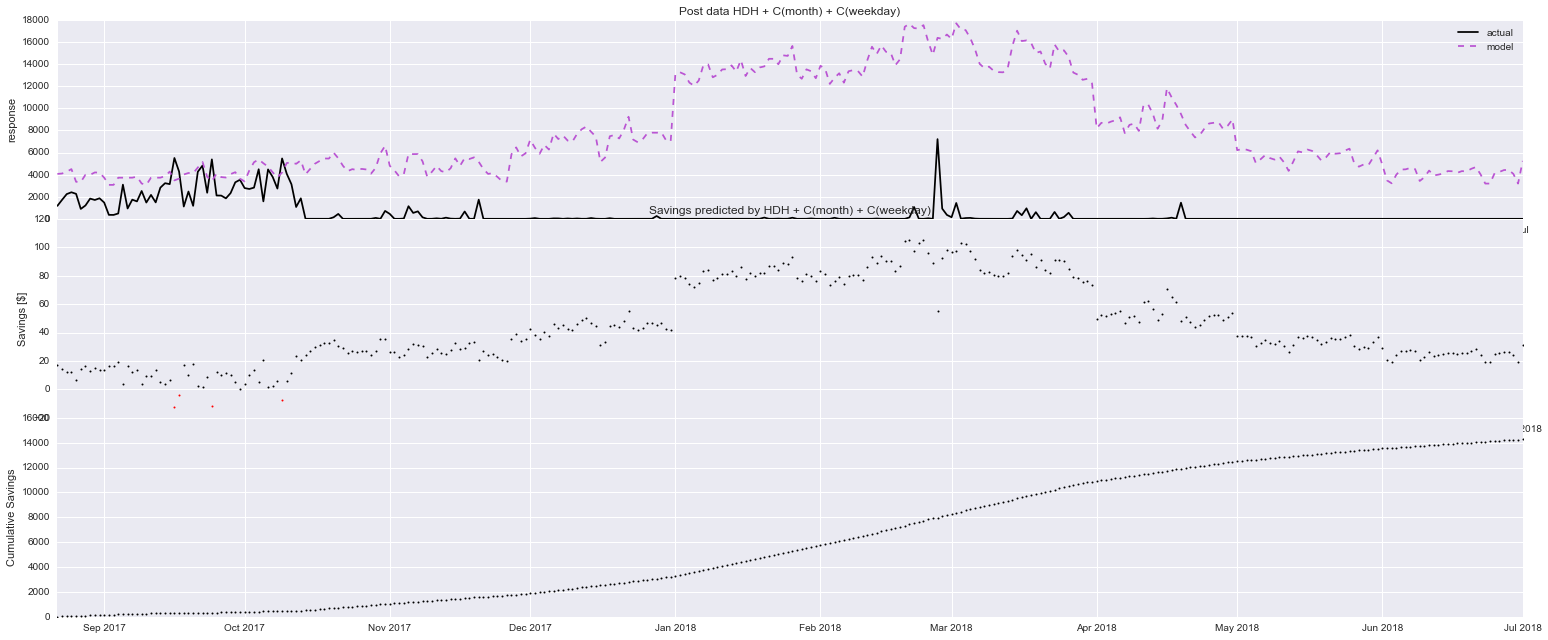

In [60]:
#rates = {'chw':0.056, 'steam':0.0157, 'elec':0.030} #kBTU prices for 2016(?)
#commodity = 'chw'

savings = round(mod.postCumsum * mod.params.commodityRate,2)
print("Savings = $" + str(round(mod.postCumsum * mod.params.commodityRate,2)))
print("Savings = %.0f klbs") %(savings/mod.params.commodityRate)
mod.savings_plot(yaxis='dollars')

In [59]:
per_day = savings/mod.params.commodityRate / len(mod.postDiff)
print("Estimated FY Savings = %.0f klbs") %(per_day * 365)

Estimated FY Savings = 2767179 klbs
